KHAI BÁO THƯ VIỆN

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import joblib
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import resample

ĐỌC FILE

In [77]:
df = pd.read_csv(r"../data/HAM10000_metadata.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10124 non-null  object 
 1   image_id      10124 non-null  object 
 2   dx            10124 non-null  object 
 3   dx_type       10124 non-null  object 
 4   age           10067 non-null  float64
 5   sex           10124 non-null  object 
 6   localization  10124 non-null  object 
 7   dataset       10124 non-null  object 
dtypes: float64(1), object(7)
memory usage: 632.9+ KB


In [78]:
df.shape

(10124, 8)

In [79]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


XEM VÀ XỬ LÍ MISSING VALUES

In [80]:
null_values = (df.isnull().sum() / df.shape[0] ) * 100
print(" % null mỗi cột:\n", null_values)

 % null mỗi cột:
 lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.563019
sex             0.000000
localization    0.000000
dataset         0.000000
dtype: float64


In [81]:
# Do missing values chỉ xuất hiện ở cột "age" và tỉ lệ thấp => giữ và thay bằng giá trị trung vị của cột
df["age"] = df["age"].fillna(df["age"].median())
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
dtype: int64

Text(0.5, 0, 'Age')

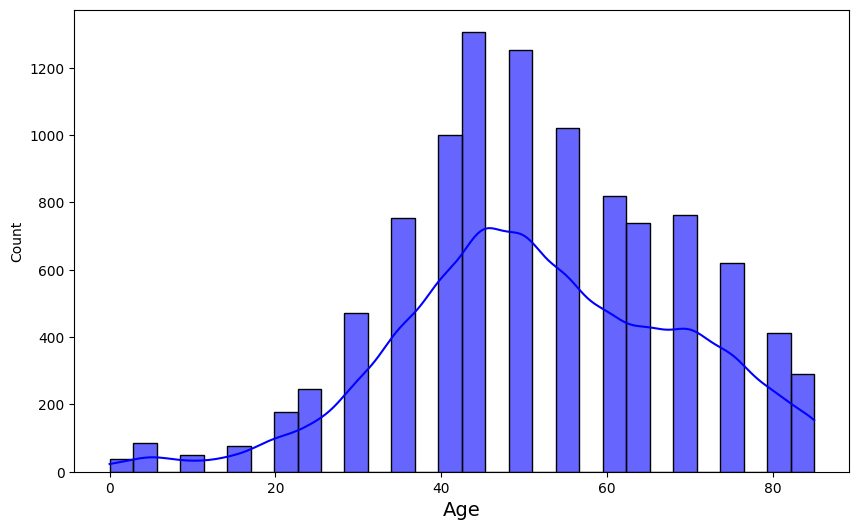

In [82]:
#Hiển thị phân phối của các cột dữ liệu số
plt.figure(figsize=(10,6))
sns.histplot(df['age'], bins=30, kde=True, color='blue', alpha=0.6)
plt.xlabel('Age', fontsize=14)

KIỂM TRA VÀ XỬ LÍ CÂN BẰNG DỮ LIỆU

In [83]:
df['dx'].value_counts()

dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
vasc        142
df          115
healthy     109
Name: count, dtype: int64

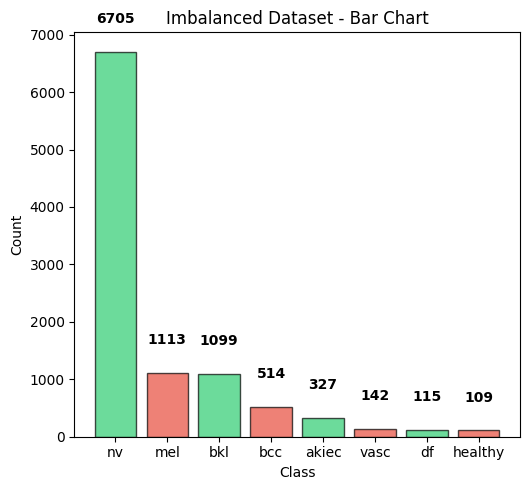

In [84]:
plt.figure(figsize=(10, 5))

# Bar plot
plt.subplot(1, 2, 1)
dx_counts = df['dx'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.bar(['nv','mel','bkl','bcc','akiec','vasc','df','healthy'], dx_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Imbalanced Dataset - Bar Chart')

for i, v in enumerate(dx_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Downsampling cột nv để giảm imbalance. ( lí do chọn vì dữ liệu này là về y tế cho nên sinh thêm dữ liệu có thể gây sai lầm lớn, downsampling cho tất cả các cột tương đương nhau thì dữ liệu còn quá ít )

In [85]:
# Hàm downsampling để cân bằng dataset
def balance_dataset_by_type(data):

    # Tách dữ liệu 
    mel_df = data[data["dx"] == "mel"]  
    nv_df = data[data["dx"] == "nv"]      # downsample 
    other_df = data[~data["dx"].isin(["mel", "nv"])]  # giữ nguyên các lớp khác
    
    # Downsample lớp "nv" để có cùng số lượng mẫu như lớp "mel"
    nv_downsampled = resample(
        nv_df,
        replace=False,
        n_samples=len(mel_df) + 50,  # Thêm một chút mẫu để tránh mất quá nhiều dữ liệu
        random_state=42
    )

    # Kết hợp lại dữ liệu đã cân bằng
    balanced_data = pd.concat(
        [mel_df, nv_downsampled, other_df],
        ignore_index=True
    ).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_data

# Cân bằng lại dataset
df_balanced = balance_dataset_by_type(df)


In [86]:
df_balanced.shape

(4582, 8)

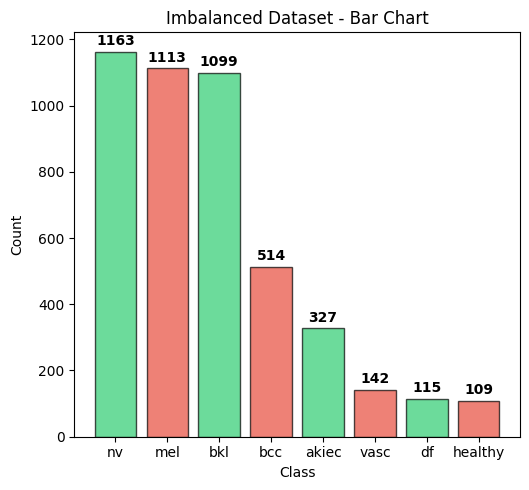

In [87]:
plt.figure(figsize=(10, 5))

# Bar plot
plt.subplot(1, 2, 1)
dx_counts = df_balanced['dx'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.bar(['nv','mel','bkl','bcc','akiec','vasc','df','healthy'], dx_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Imbalanced Dataset - Bar Chart')

for i, v in enumerate(dx_counts.values):
    plt.text(i, v+ 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

=> dữ liệu bị mất cân bằng. Dùng class_weight + stratify + macro F1 để giảm mất cân bằng dữ liệu.

LABEL MAPPING

In [88]:
# Loại bỏ class "healthy" để chuyển sang bài toán phân loại đa lớp cho da bệnh
df = df[df["dx"] != "healthy"]

In [89]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset'],
      dtype='object')

In [90]:
dx_dict = {
    "nv": "Melanocytic nevus",
    "mel": "Melanoma",
    "bkl": "Benign keratosis",
    "bcc": "Basal cell carcinoma",
    "akiec": "Actinic keratoses",
    "vasc": "Vascular lesions",
    "df": "Dermatofibroma",
}

df["diagnosis"] = df["dx"].map(dx_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,diagnosis
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis


In [91]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()}" )

lesion_id: 7470
image_id: 10015
dx: 7
dx_type: 4
age: 18
sex: 3
localization: 15
dataset: 4
diagnosis: 7


Label encoding cho multi-class

In [92]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["diagnosis"])

CHỌN FEATURES VÀ TARGET

In [93]:
features = df.drop(columns=['lesion_id','image_id', 'dx', 'diagnosis', 'label'])
target = df['label']

ONE HOT ENCODE CHO FEATURES

In [94]:
# One-hot encode categorical features
cat_cols = ["dx_type", "sex", "localization", "dataset"]

df_encoded = pd.get_dummies(
    features,
    columns=cat_cols,
    drop_first=False
)

# Chuyển đổi kiểu dữ liệu sang int
df_encoded = df_encoded.astype(int)


CHIA TẬP DỮ LIỆU HUẤN LUYỆN

In [95]:
# stratify=target: giữ nguyên tỷ lệ các lớp (nhãn) trong tập train và test
x_train ,x_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.2, random_state=42, stratify=target)

In [96]:
print(x_train.shape)
print(y_train.shape)
print("------------------")
print(x_test.shape)
print(y_test.shape)

(8012, 27)
(8012,)
------------------
(2003, 27)
(2003,)


CHUẨN HÓA DỮ LIỆU

In [97]:
# Chuẩn hóa dữ liệu 
num_cols = features.select_dtypes(include=["int64", "float64"]).columns

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

scaler = StandardScaler()
x_train_scaled[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test_scaled[num_cols] = scaler.transform(x_test[num_cols])

In [98]:
print(x_train_scaled)

           age  dx_type_confocal  dx_type_consensus  dx_type_follow_up  \
5783  1.078801                 0                  0                  1   
7864 -1.288593                 0                  0                  0   
328   0.782877                 0                  0                  0   
8566 -1.288593                 0                  0                  0   
1401  1.078801                 0                  0                  0   
...        ...               ...                ...                ...   
1312 -0.992668                 0                  0                  0   
1816  0.782877                 0                  0                  0   
9501 -0.400820                 0                  1                  0   
6993 -1.584517                 0                  0                  0   
2984 -0.400820                 0                  0                  1   

      dx_type_histo  sex_female  sex_male  sex_unknown  localization_abdomen  \
5783              0           1

VISUALIZE t-SNE 

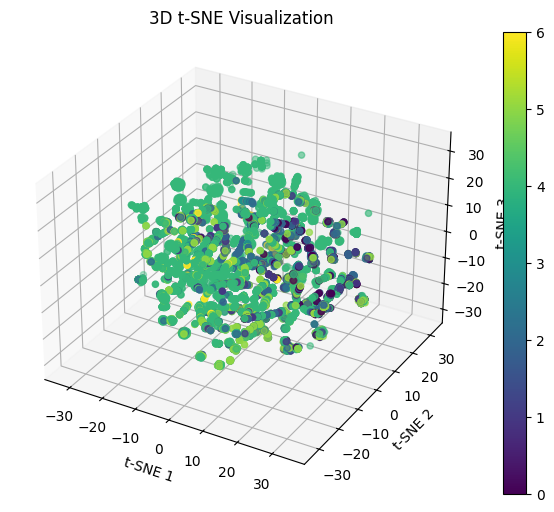

In [99]:
tsne = TSNE(n_components=3, random_state=42)
X_train_tsne_3d = tsne.fit_transform(x_train_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_train_tsne_3d[:,0],
    X_train_tsne_3d[:,1],
    X_train_tsne_3d[:,2],
    c=y_train,
    cmap='viridis'
)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('3D t-SNE Visualization')

plt.colorbar(scatter)
plt.show()

In [100]:
"""
- Biểu đồ t-SNE 3D cho thấy các lớp bệnh da không tạo thành các cụm tách biệt rõ ràng, mà chồng chéo mạnh trong không gian đặc trưng.
- Ranh giới giữa các lớp không rõ ràng, đặc biệt ở vùng trung tâm nơi nhiều lớp cùng xuất hiện.
- Hiện tượng chồng chéo này phản ánh đặc trưng giữa các bệnh có sự tương đồng cao, khiến bài toán phân loại đa lớp trở nên phức tạp và khó khăn.
"""

'\n- Biểu đồ t-SNE 3D cho thấy các lớp bệnh da không tạo thành các cụm tách biệt rõ ràng, mà chồng chéo mạnh trong không gian đặc trưng.\n- Ranh giới giữa các lớp không rõ ràng, đặc biệt ở vùng trung tâm nơi nhiều lớp cùng xuất hiện.\n- Hiện tượng chồng chéo này phản ánh đặc trưng giữa các bệnh có sự tương đồng cao, khiến bài toán phân loại đa lớp trở nên phức tạp và khó khăn.\n'

SAVE AND LOAD DATASET

In [101]:
# Add code to save dataset and load it later

joblib.dump(x_train_scaled, '../data/multi_class/x_train_scaled_multi_class.pkl')
joblib.dump(x_test_scaled, '../data/multi_class/x_test_scaled_multi_class.pkl')
joblib.dump(y_train, '../data/multi_class/y_train_multi_class.pkl')
joblib.dump(y_test, '../data/multi_class/y_test_multi_class.pkl')
joblib.dump(le, "../data/multi_class/label_encoder.pkl")


['../data/multi_class/label_encoder.pkl']